In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline


In [2]:
#internal
from clustering.kde import weighted_gaussian_kde
import clustering.projected_correlation_functions as w
import clustering.BASS_randoms as rand
from clustering.utils import wp_d1d2,wp_dd

Assumes BASS catalog, galaxy catalogs, and sensitivity maps are in folder `data_directory'

## Initialize the cosmology
see here for reference: http://docs.astropy.org/en/stable/cosmology/

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Read in AGN catalog
From Swift/BAT AGN Spectroscopic Survey: Local, hard X-ray selected

In [4]:
data_directory = '/home/mcpowell/data/Data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

List the names of the columns in the catalog. For the clustering code, you need at least 'ra', 'dec', and 'z'

In [5]:
agnt.dtype.names

('ID',
 'name',
 'z',
 'ra',
 'dec',
 'l',
 'b',
 'flux',
 'type',
 'log_Mbh',
 'Lum. dist',
 'method',
 'cdist',
 'log_L210',
 'log_L14150',
 'nH',
 'log_Ms',
 'Lir',
 'Lir_sf',
 'afrac')

Limit catalog to preferred luminosity & redshift range  
Here, we choose AGN with X-ray luminosities $>10^{42.5}$ erg/s, in the redshift range $0.01<z<0.1$:

In [6]:
agn = agnt[ (agnt['log_L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]

In [7]:
len(agn) #gives number of AGN in catalog (length of the array)

499

## Read in galaxy catalog

In [8]:
t = Table.read(data_directory +'galaxy_cats/2mrs_v240/2mrs_noAGN.csv',format='csv')
gal =np.array(t)

In [9]:
gal.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'cdist')

In [10]:
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
len(gal)

38567

## Plot positions of AGN, galaxies on the sky

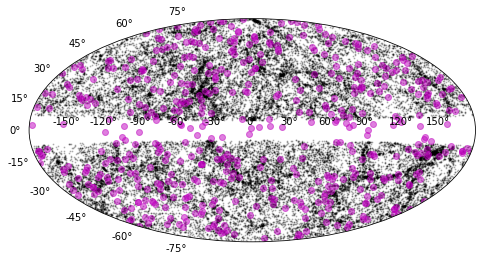

In [11]:
ra1 = coord.Angle(agn['l']*u.degree)
ra1 = ra1.wrap_at(180*u.degree)
dec1 = coord.Angle(agn['b']*u.degree)

ra2 = coord.Angle(gal['l']*u.degree)
ra2 = ra2.wrap_at(180*u.degree)
dec2 = coord.Angle(gal['b']*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
#y1 = coord.Angle(8*u.degree)
#y2 = coord.Angle(-8*u.degree)

ax.scatter(ra2.radian, dec2.radian,1,color='k',alpha=.2)
ax.scatter(ra1.radian, dec1.radian,color='m',alpha=.5)


## Make random catalogs

number of randoms: 50803


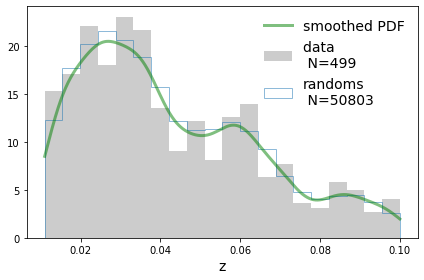

In [12]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)

#100: 100X randoms as AGN

In [13]:
arand.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'flux', 'cdist')

number of randoms: 887041


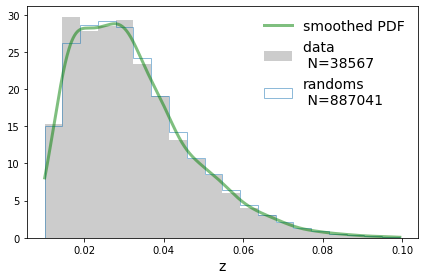

In [14]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

## specify clustering parameters
pi_max: maximum seperation in redshift space that we integrate to (max length we average over)  
nbins: number of projected spatial bins

In [15]:
pimax=60
nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)

## Autocorrelate AGN

Using the Landy-Szalay estimator for the correlation function:   

$\xi(r_{p},\pi) = \frac{DD - 2DR + RR}{RR}$   
DD: # data-data pairs   
DR: # data-random pairs    
RR: # random-random pairs   

$w_{p} = 2 \int^{\pi_{\rm{max}}}_{0} \xi(r_{p},\pi) d\pi$

$r_p$: spatial separation perpendicular to the line of sight   
$\pi$: spatial separation parallel to the line of sight   

In [16]:
rp,wp_aa,wp_aa_err,cov = w.auto_wp(agn, arand, bins, pimax, 5, estimator='L')
# the 5 refers to the square root of the number of jackknife samples used to estimate the errors


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.002 sec
Using AVX512 kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.155 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   

Using  25  jacknife samples
1 / 25
2 / 25


...80%.........90%.........100% done. Time taken =  0.149 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 13,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


3 / 25
4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%........

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%........

7 / 25
8 / 25


....30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.

9 / 25
10 / 25


......50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.142 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs
In gridlink_m

11 / 25
12 / 25


......60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs
In gridlink_mocks_double>

13 / 25
14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlin

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%........

17 / 25
18 / 25


.....30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,11,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0

19 / 25
20 / 25


....40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.151 secs
In 

21 / 25
22 / 25


.....50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs
In gridlink_mo

23 / 25
24 / 25


....60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,13,7.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.142 secs
In gridlink_mocks_double> R

25 / 25


....60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs


Plot

Text(0.5, 1.0, 'AGN ACF')

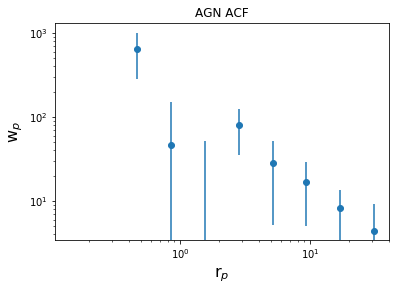

In [17]:
plt.yscale("log", nonposy='clip')
plt.xscale("log")
plt.errorbar(rp,wp_aa,yerr=wp_aa_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN ACF')

There's a signal, but the errors are pretty large

## Cross-correlate AGN with galaxies

$\xi(r_{p},\pi) = \frac{D_{1}D_{2} - D_{1}R_{2} - D_{2}R_{1} + R_{1}R_{2}}{R_{1}R_{2}}$   

1: AGN   
2: Galaxies

In [18]:
t1=time.time()
rp,wp_ag,wp_ag_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')
t = time.time() - t1

In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 485. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mo

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mo

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.281 secs
In gridlink_mo

3 / 25


.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.262 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 451. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%..

4 / 25


 Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.278 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 460. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken = 

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 480. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mo

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 475. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.293 secs
In gridlink_mo

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 465. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.282 secs
In gridlink_mo

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 459. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.278 secs
In gridlink_mo

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 464. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.278 secs
In gridlink_mo

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.291 secs
In gridlink_mo

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 481. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.298 secs
In gridlink_mo

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 458. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.272 secs
In gridlink_mo

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 450. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.269 secs
In gridlink_mo

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.271 secs
In gridlink_mo

15 / 25


 Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.294 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken = 

16 / 25


 Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.294 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 477. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken = 

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 467. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.290 secs
In gridlink_mo

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.279 secs
In gridlink_mo

19 / 25


......40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.....

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.293 secs
In gridlink_mo

21 / 25


 Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.302 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken = 

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.278 secs
In gridlink_mo

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 452. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.303 secs
In gridlink_mo

24 / 25


 Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.283 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 466. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken = 

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 478. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.307 secs
In gridlink_mo

In [19]:
print('took ',str(t/60),' minutes')

took  2.38573207060496  minutes


Text(0.5, 1.0, 'AGN XCF')

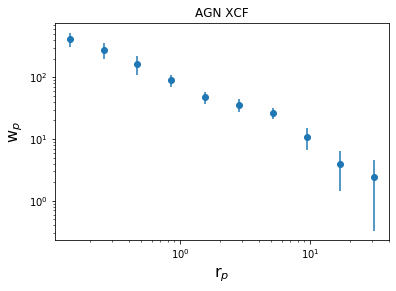

In [20]:
plt.yscale("log", nonposy='clip')
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')

better!

Try another estimator (Davis & Peebles):
$\xi(r_{p},\pi) = \frac{D_{1}D_{2}}{D_{1}R_{2}} - 1$   

In [21]:
#%%timeit
t1=time.time()
rp,wp_agp,wp_agp_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')
t = time.time() - t1

In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 485. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mo

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 451. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 460. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 480. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 475. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 465. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,13,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,13,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 459. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 464. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 481. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 458. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 450. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 477. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 467. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,13,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,13,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,22,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 474. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 452. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 466. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,14,7.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 478. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs


In [22]:
print('took ',str(t),' seconds')

took  7.481409549713135  seconds


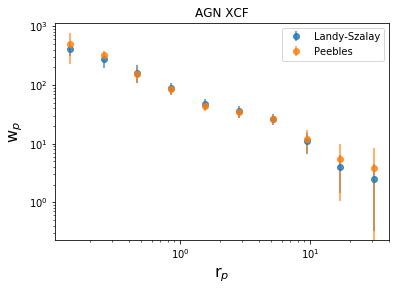

In [25]:
plt.yscale("log", nonposy='clip')
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o',label='Landy-Szalay',alpha=0.8)
plt.errorbar(rp,wp_agp,yerr=wp_agp_err,fmt='o',label='Peebles',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()

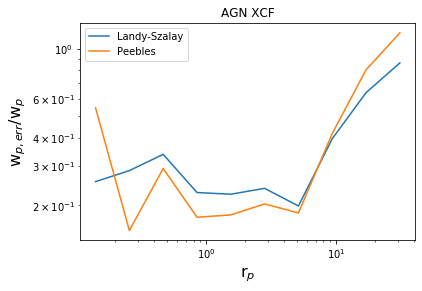

In [27]:
plt.yscale("log", nonposy='clip')
plt.xscale("log")
plt.plot(rp,wp_ag_err/wp_ag,label='Landy-Szalay')
plt.plot(rp,wp_agp_err/wp_agp,label='Peebles')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p,err}$/w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()